### Setup Environment:

In [1]:
from src.get_dataset import get_dataset, split_data
from src.data_loader import BRSETDataset, process_labels
from src.model import FoundationalCVModel, FoundationalCVModelWithClassifier
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
import os
import matplotlib.pyplot as plt
import numpy as np

# loss function and optimizer
from src.FocalLoss import BinaryFocalLoss, FocalLoss

# train and test functions
from src.train import train
from src.test import test

In [2]:
# Constants:
DATASET = '/opc/davidres/retina/mbrset/data'
DOWNLOAD = False
SHAPE = (224, 224)
IMAGES = os.path.join(DATASET, 'mBRSET/')
LABEL = 'insurance'
TEST_SIZE = 0.2
UNDERSAMPLE = False

LABELS_PATH = os.path.join(DATASET, 'labels.csv')
IMAGE_COL = 'file'

"""
Dataset Mean and Std:
NORM_MEAN = [0.5896205017400412, 0.29888971649817453, 0.1107679405196557]
NORM_STD = [0.28544273712830986, 0.15905456049750208, 0.07012281660980953]

ImageNet Mean and Std:
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]
"""

NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD =  [0.229, 0.224, 0.225]

BACKBONE = 'dinov2_large'
MODE = 'fine_tune'
backbone_mode = 'fine_tune'

HIDDEN = [128]
num_classes = 2

BATCH_SIZE = 16
NUM_WORKERS = 4

LOSS = 'focal_loss'
OPTIMIZER = 'adam'

# Define your hyperparameters
num_epochs = 50
learning_rate = 1e-5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### Read csv file:

In [3]:
df = get_dataset(DATASET, download=DOWNLOAD, info=False)
df = df[df['file'] != '985.1.jpg'] # this is missing
df.head()

loading csv file in /home/chenweiw/retina/mbrset/data/labels.csv


,patient,age,sex,dm_time,insulin,insulin_time,oraltreatment_dm,systemic_hypertension,insurance,educational_level,...,nephropathy,neuropathy,diabetic_foot,file,laterality,final_artifacts,final_quality,final_icdr,final_edema,normality
0,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.1.jpg,right,yes,yes,4.0,no,abnormal
1,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.2.jpg,right,yes,yes,4.0,no,abnormal
2,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.3.jpg,left,yes,yes,4.0,no,abnormal
3,1,58,1,15.0,1.0,NaN,1.0,1.0,0.0,3.0,...,1.0,0.0,0.0,1.4.jpg,left,yes,yes,4.0,no,abnormal
4,10,63,0,7.0,0.0,NaN,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,10.1.jpg,right,yes,yes,0.0,no,abnormal


In [4]:
df.insurance.value_counts()

0.0    4719
1.0     396
Name: insurance, dtype: int64

In [5]:

df[LABEL] = df[LABEL].apply(lambda x: '0' if x == 0 else '1')

Train data shape: (4130, 25)
Test data shape: (1033, 25)


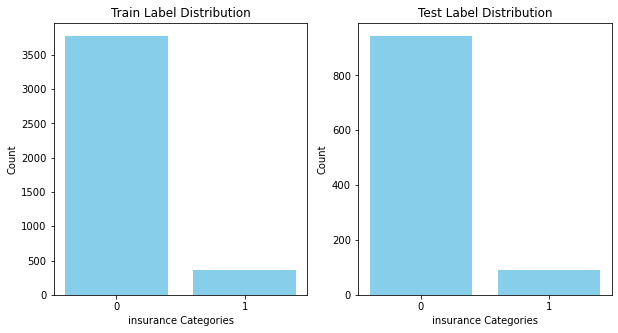

Getting validation set...


In [6]:
# Split dataset into train, test and validation:
df_train, df_test = split_data(df, LABEL, TEST_SIZE, undersample=False)
print('Getting validation set...')
# df_test, df_val = split_data(df_test, LABEL, 0.20)
df_val=df_test

### Dataloaders

In [7]:
# Train the one hot encoder on the train set and get the labels for the test and validation sets:
train_labels, mlb, train_columns = process_labels(df_train, col=LABEL)

In [8]:
# Define the target image shape
SHAPE = (224, 224)  # Adjust to your desired image size

train_transforms = transforms.Compose([
    transforms.Resize((SHAPE)),
    # transforms.RandomCrop(SHAPE),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(25),  # Randomly rotate the image by up to 10 degrees
])

if NORM_MEAN is not None and NORM_STD is not None:
    train_transforms.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))

test_transform = transforms.Compose([
    transforms.Resize(SHAPE),
    transforms.ToTensor(),
])

if NORM_MEAN is not None and NORM_STD is not None:
    test_transform.transforms.append(transforms.Normalize(mean=NORM_MEAN, std=NORM_STD))


In [9]:
# Create the custom dataset
train_dataset = BRSETDataset(
    df_train, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=train_transforms
)

test_dataset = BRSETDataset(
    df_test, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

val_dataset = BRSETDataset(
    df_val, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


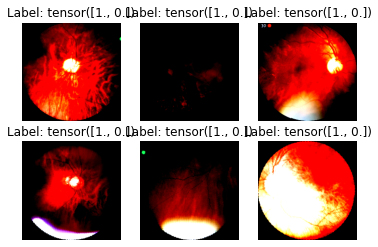

In [10]:
# Print 6 samples with their labels
# Iterate through the DataLoader and plot the images with labels
for batch in train_dataloader:
    images, labels = batch['image'], batch['labels']

    for i in range(len(images)):
        if i == 6:
            break
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))  # Permute to (H, W, C) from (C, H, W)
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.show()
    break

### Model

In [11]:
# Create the model
backbone_model = FoundationalCVModel(backbone=BACKBONE, mode=MODE)
model = FoundationalCVModelWithClassifier(backbone_model, hidden=HIDDEN, num_classes=num_classes, mode=MODE, backbone_mode=backbone_mode)
model.to(device)

# Use DataParallel to parallelize the model across multiple GPUs
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model, [0,1])

Using cache found in /home/chenweiw/.cache/torch/hub/facebookresearch_dinov2_main


### Training:

In [12]:
if LOSS == 'focal_loss':
    class_distribution = train_dataloader.dataset.labels.sum(axis=0)
    print(f'Class distribution: {class_distribution}')
    class_dis = np.array(class_distribution)
    class_weights =1-class_dis/np.sum(class_dis)
    weights = torch.tensor(class_weights).to(device)
    #criterion = FocalLoss()  # Focal Loss
    criterion = FocalLoss(gamma=2, alpha=weights)
else:
    # Assuming train_loader.dataset.labels is a one-hot representation
    class_indices = np.argmax(train_dataloader.dataset.labels, axis=1)

    # Compute class weights using class indices
    class_weights = compute_class_weight('balanced', classes=np.unique(class_indices), y=class_indices)
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    criterion = nn.CrossEntropyLoss(weight=class_weights).to(device)
    #criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy Loss

if OPTIMIZER == 'adam':
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
elif OPTIMIZER == 'adamw':
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
else:
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

Class distribution: [3775  355]


In [13]:
model = train(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs=num_epochs, save=True, device=device, backbone=f'{BACKBONE}_{num_classes}class_{LABEL}')

100%|██████████| 65/65 [00:13<00:00,  4.79it/s]


Epoch 1, Train Loss: 0.03255969391053391, Val Loss: 0.029225441039754795, F1 Score: 0.07932263814616755, acc0.08615682478218781
cm[[  0 944]
 [  0  89]]


100%|██████████| 65/65 [00:13<00:00,  4.83it/s]


Epoch 2, Train Loss: 0.028639701175284086, Val Loss: 0.027796116199057835, F1 Score: 0.47749114820435, acc0.9138431752178122
cm[[944   0]
 [ 89   0]]


100%|██████████| 65/65 [00:13<00:00,  4.87it/s]


Epoch 3, Train Loss: 0.027926241899894472, Val Loss: 0.02709426237986638, F1 Score: 0.5297440434972174, acc0.8625363020329139
cm[[880  64]
 [ 78  11]]


100%|██████████| 65/65 [00:13<00:00,  4.92it/s]


Epoch 4, Train Loss: 0.028010726235735025, Val Loss: 0.027887631150392386, F1 Score: 0.07932263814616755, acc0.08615682478218781
cm[[  0 944]
 [  0  89]]


100%|██████████| 65/65 [00:13<00:00,  4.94it/s]


Epoch 5, Train Loss: 0.027483578120505718, Val Loss: 0.02664839423333223, F1 Score: 0.5113900705621847, acc0.6931268151016456
cm[[673 271]
 [ 46  43]]


100%|██████████| 65/65 [00:13<00:00,  4.84it/s]


Epoch 6, Train Loss: 0.02709316463716702, Val Loss: 0.028423778684093404, F1 Score: 0.47749114820435, acc0.9138431752178122
cm[[944   0]
 [ 89   0]]


100%|██████████| 65/65 [00:13<00:00,  4.74it/s]


Epoch 7, Train Loss: 0.027245319959020752, Val Loss: 0.02811259335050216, F1 Score: 0.5050869430431474, acc0.8683446272991288
cm[[891  53]
 [ 83   6]]


100%|██████████| 65/65 [00:13<00:00,  4.73it/s]


Epoch 8, Train Loss: 0.027234381406377413, Val Loss: 0.029433081671595574, F1 Score: 0.47749114820435, acc0.9138431752178122
cm[[944   0]
 [ 89   0]]


100%|██████████| 65/65 [00:13<00:00,  4.84it/s]


Epoch 9, Train Loss: 0.027001982500855757, Val Loss: 0.02773322179340399, F1 Score: 0.07932263814616755, acc0.08615682478218781
cm[[  0 944]
 [  0  89]]


100%|██████████| 65/65 [00:13<00:00,  4.87it/s]


Epoch 10, Train Loss: 0.026697763709286695, Val Loss: 0.02721918294062981, F1 Score: 0.509534363702631, acc0.7666989351403679
cm[[770 174]
 [ 67  22]]
Early stopping triggered.


### Test

100%|██████████| 65/65 [00:13<00:00,  4.93it/s]


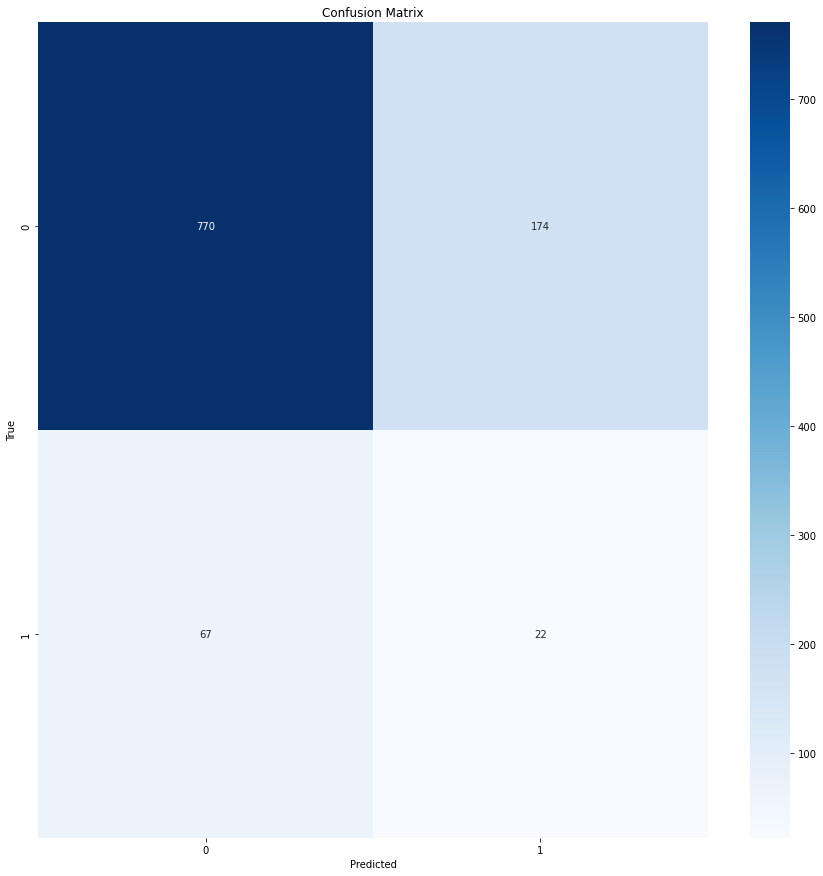

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


              precision    recall  f1-score   support

           0       0.92      0.82      0.86       944
           1       0.11      0.25      0.15        89

    accuracy                           0.77      1033
   macro avg       0.52      0.53      0.51      1033
weighted avg       0.85      0.77      0.80      1033

##################################################  Saliency Maps  ##################################################

Class 0:


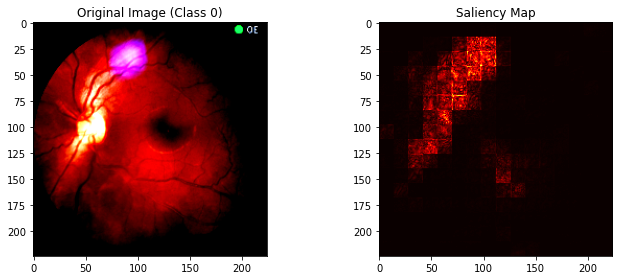

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


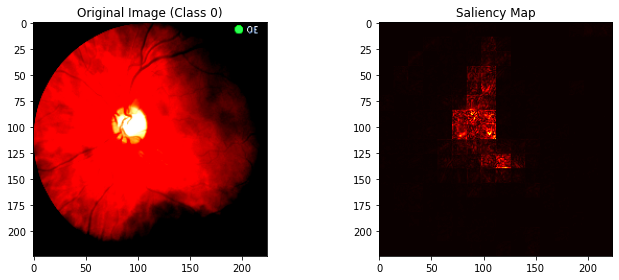

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


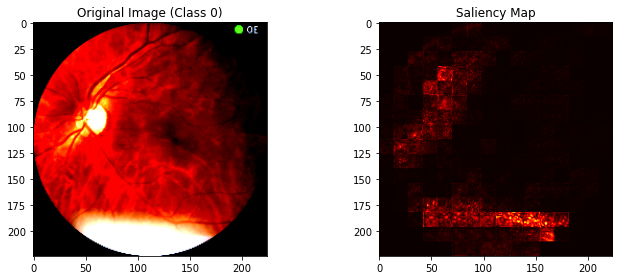

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


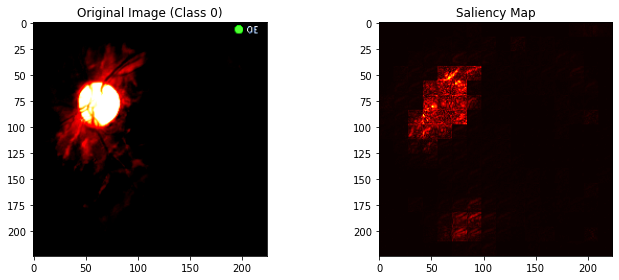

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


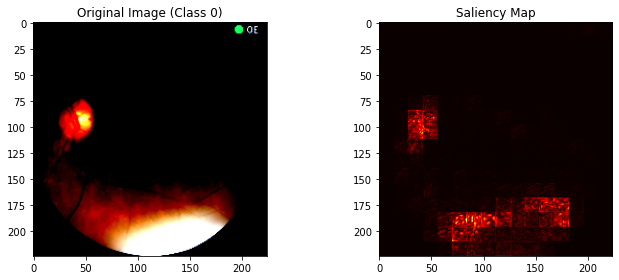

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Class 1:


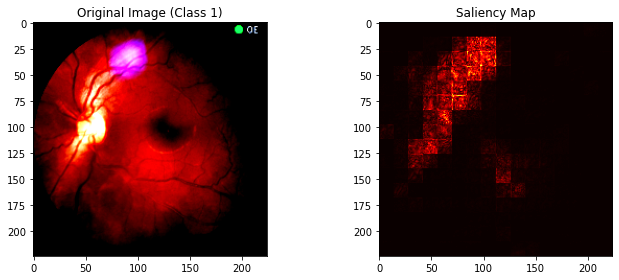

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


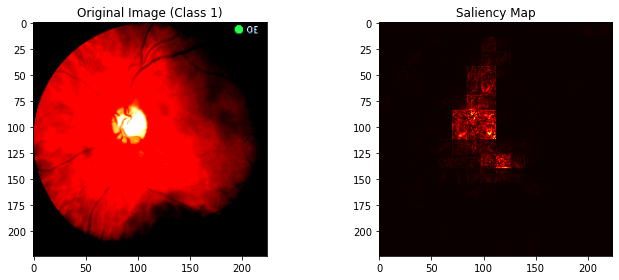

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


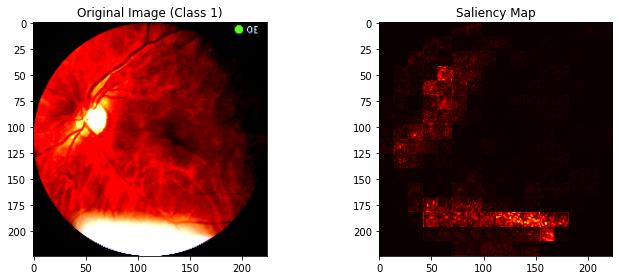

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


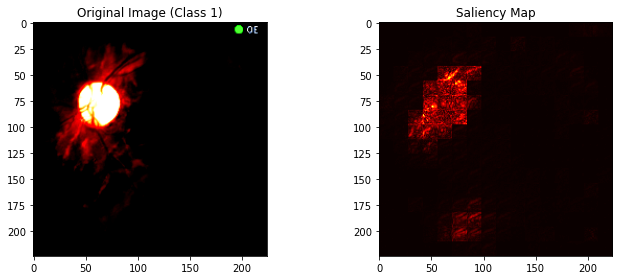

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


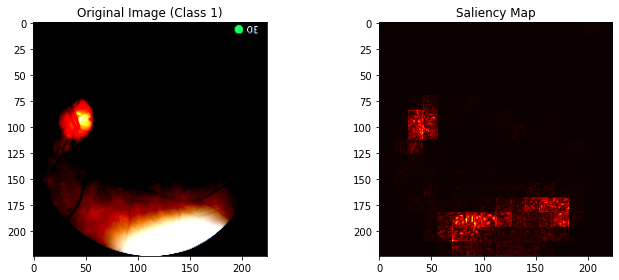

In [14]:
test(model, test_dataloader, saliency=True, device=device)

In [ ]:
# Good quality images
adequate_df = df_test[df_test['final_quality'] == 'yes']

# Bad quality images
inadequate_df = df_test[df_test['final_quality'] == 'no']

adequate_dataset = BRSETDataset(
    adequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

inadequate_dataset = BRSETDataset(
    inadequate_df, 
    IMAGE_COL, 
    IMAGES, 
    LABEL, 
    mlb, 
    train_columns, 
    transform=test_transform
)

adequate_dataloader = DataLoader(adequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
inadequate_dataloader = DataLoader(inadequate_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

#### Adequate image quality

In [ ]:
test(model, adequate_dataloader, saliency=True, device=device, save=True)

#### Inadequate image quality

In [ ]:
test(model, inadequate_dataloader, saliency=True, device=device)